### Importar de Bibliotecas:

In [1]:
from __future__ import print_function, division

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.image import imread
from IPython.display import Image, display
from PIL import Image as Imagem

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable

import numpy as np
import os
import time
import copy
import time
from datetime import timedelta

import tensorflow as tf
from tensorboardX import SummaryWriter

plt.ion()

In [2]:
#### Verificação das Versões

In [3]:
tf.__version__

'1.14.0'

In [4]:
torch.__version__

'1.3.0'

#### Importar funções e classes provenientes dos arquivos inception.py e knifey.py
As funções e classes knifey e inception irão nos auxiliar ao tentarmos dividir o dataset em clusters

In [5]:
import knifey

In [6]:
import inception

In [7]:
knifey.data_dir = "data/movedataset/"
data_dir = knifey.data_dir
dataset = knifey.load()

Creating dataset from the files in: data/movedataset/
- Data loaded from cache-file: data/movedataset/knifey-spoony.pkl


In [8]:
class_names = dataset.class_names
class_names

['conformes', 'nao-conformes']

In [9]:
num_classes = len(class_names)

In [10]:
image_paths_train, cls_train, labels_train = dataset.get_training_set()
image_paths_test, cls_test, labels_test = dataset.get_test_set()

In [11]:
print (image_paths_train[0])
print (image_paths_test[0])

C:\Users\bruno\Documents\TCC\Codes\data\movedataset\conformes\20191008_151115.jpg
C:\Users\bruno\Documents\TCC\Codes\data\movedataset\conformes\test/20191008_151033(0).jpg


In [12]:
print("Dimensões:")
print("- Dados de Treino:\t\t{}".format(len(image_paths_train)))
print("- Dados de Teste:\t\t{}".format(len(image_paths_test)))

Dimensões:
- Dados de Treino:		149
- Dados de Teste:		82


### Função Auxiliar para Mostrar as Imagens

Função usada para mostrar 9 imagens em um
a tabela 3x3 e escrever o valor real e a predição abaixo de cada imagem:

In [13]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Função auxiliar para carregar as imagens

Essa função carrega alguns arquivos de imagens

In [14]:

def load_images(image_paths):
    # Load the images from disk.
    images = [imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

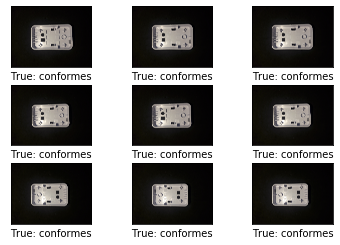

In [15]:
# Load the first images from the test-set.
images = load_images(image_paths=image_paths_test[0:9])

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

#### Download do Modelo Inception

In [16]:
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


In [17]:
#### Carregar o Modelo Inception

In [18]:
model = inception.Inception()

Instructions for updating:
Use tf.gfile.GFile.




#### Calcular Valores de Transferência

Importar uma função auxiliar para manter os valores de transferência do modelo inception em cache.

In [19]:
from inception import transfer_values_cache

Setar os caminhos para armazenar os dados de treino e de teste em cache (arquivo plk)

In [20]:
file_path_cache_train = os.path.join(data_dir, 'inception-tcc-train.pkl')
file_path_cache_test = os.path.join(data_dir, 'inception-tcc-test.pkl')

In [21]:
print("Processing Inception transfer-values for training-images ...")

# If transfer-values have already been calculated then reload them,
# otherwise calculate them and save them to a cache-file.
transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              image_paths=image_paths_train,
                                              model=model)

Processing Inception transfer-values for training-images ...
- Data loaded from cache-file: data/movedataset/inception-tcc-train.pkl


In [22]:
print("Processing Inception transfer-values for test-images ...")

# If transfer-values have already been calculated then reload them,
# otherwise calculate them and save them to a cache-file.
transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             image_paths=image_paths_test,
                                             model=model)

Processing Inception transfer-values for test-images ...
- Data loaded from cache-file: data/movedataset/inception-tcc-test.pkl


In [23]:
### Dimensão dos valores de transferência

In [24]:
print('Train:')
transfer_values_train.shape

Train:


(149, 2048)

In [25]:
print('Test:')
transfer_values_test.shape

Test:


(82, 2048)

#### Função Auxiliar para visualização dos valores de transferência

In [26]:
def plot_transfer_values(i):
    print("Input image:")
    
    # Plot the i'th image from the test-set.
    image = imread(image_paths_test[i])
    plt.imshow(image, interpolation='spline16')
    plt.show()
    
    print("Transfer-values for the image using Inception model:")
    
    # Transform the transfer-values into an image.
    img = transfer_values_test[i]
    img = img.reshape((32, 64))

    # Plot the image for the transfer-values.
    plt.imshow(img, interpolation='nearest', cmap='Reds')
    plt.show()

In [27]:
### Visualização dos valores de transferência de duas imagens do conjunto de teste

Input image:


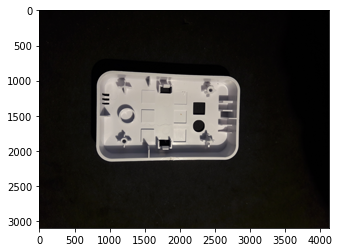

Transfer-values for the image using Inception model:


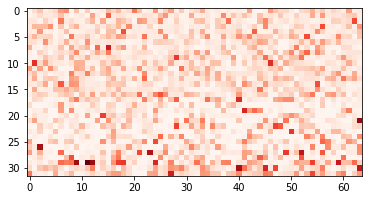

In [28]:
plot_transfer_values(i=20)

Input image:


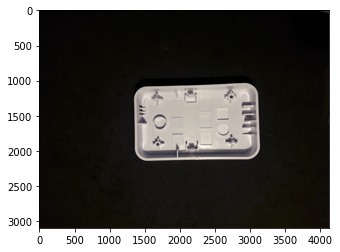

Transfer-values for the image using Inception model:


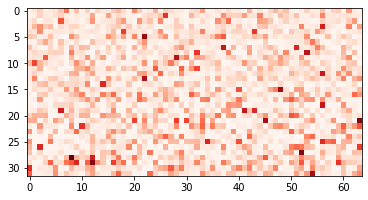

In [29]:
plot_transfer_values(i=80)

#### Analise dos valores de transferência usando PCA 
--- Principal Component Analysis---

In [30]:
from sklearn.decomposition import PCA

In [31]:
pca = PCA(n_components = 2)

In [32]:
transfer_values = transfer_values_train

In [33]:
cls = cls_train

In [34]:
transfer_values.shape

(149, 2048)

In [35]:
transfer_values_reduced = pca.fit_transform(transfer_values)

In [36]:
transfer_values_reduced.shape

(149, 2)

#### Função Auxiliar para mostrar a redução dos valores de transferencia:

In [37]:
def plot_scatter(values, cls):
    # Create a color-map with a different color for each class.
    import matplotlib.cm as cm
    cmap = cm.rainbow(np.linspace(0.0, 1.0, num_classes))

    # Create an index with a random permutation to make a better plot.
    idx = np.random.permutation(len(values))
    
    # Get the color for each sample.
    colors = cmap[cls[idx]]

    # Extract the x- and y-values.
    x = values[idx, 0]
    y = values[idx, 1]

    # Plot it.
    plt.scatter(x, y, color=colors, alpha=0.5)
    plt.show()

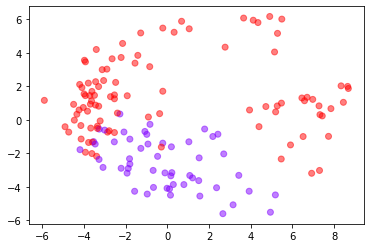

In [38]:
plot_scatter(transfer_values_reduced,cls=cls)

#### Analise dos valores de transformação usando t-SNE

In [39]:
from sklearn.manifold import TSNE

In [40]:
pca = PCA(n_components=50)
transfer_values_50d = pca.fit_transform(transfer_values)

In [41]:
tsne = TSNE(n_components=2)

In [42]:
transfer_values_reduced = tsne.fit_transform(transfer_values_50d)

In [43]:
transfer_values_reduced.shape

(149, 2)

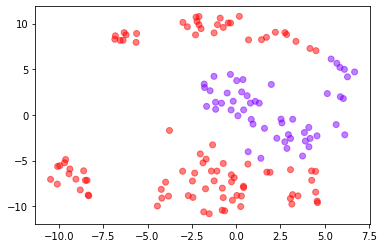

In [44]:
plot_scatter(transfer_values_reduced,cls=cls)

A partir dos resultados vistos nos gráficos acima é possível determinar que o modelo poderá ser treinado para obter resultados satisfatórios, visto que conseguimos separar as imagens em clusters bem definidos.

In [45]:
#### Novo Classificador em Tensorflow

In [46]:
#Definição dos logs de treino, validação e teste para acompanhamento via Tensorboard
log_writer_train = SummaryWriter('logs_conv/train/')
log_writer_val = SummaryWriter('logs_conv/val/')
#log_writer_test = SummaryWriter('logs/test/')

In [47]:
# Normalização dos dados para treinamento
# Normalização para a etapa de validação

In [48]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [49]:
data_dir = 'data/dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [50]:
dataloaders['train']

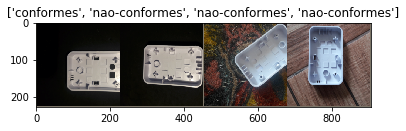

In [51]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [52]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                scheduler.step()
                log_writer_train.add_scalar('Loss',float(epoch_loss), epoch+1)
                log_writer_train.add_scalar('Accuracy', float(epoch_acc), epoch+1)
            
            elif phase =='val':
                log_writer_val.add_scalar('Loss',float(epoch_loss), epoch+1)
                log_writer_val.add_scalar('Accuracy', float(epoch_acc), epoch+1)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [53]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [54]:
#model_conv = torchvision.models.resnet18(pretrained=True)
model_conv = models.inception_v3(pretrained=True)
model_conv.aux_logits=False
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 8 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=8, gamma=0.1)

In [55]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.6923 Acc: 0.5595
val Loss: 0.5912 Acc: 0.6200

Epoch 1/29
----------
train Loss: 0.6025 Acc: 0.6786
val Loss: 0.6239 Acc: 0.6600

Epoch 2/29
----------
train Loss: 0.6024 Acc: 0.6964
val Loss: 0.4769 Acc: 0.7800

Epoch 3/29
----------
train Loss: 0.7423 Acc: 0.6131
val Loss: 0.4822 Acc: 0.7400

Epoch 4/29
----------
train Loss: 0.5533 Acc: 0.7173
val Loss: 0.5784 Acc: 0.6600

Epoch 5/29
----------
train Loss: 0.5987 Acc: 0.6875
val Loss: 0.4282 Acc: 0.8400

Epoch 6/29
----------
train Loss: 0.5568 Acc: 0.7589
val Loss: 0.4531 Acc: 0.8000

Epoch 7/29
----------
train Loss: 0.6057 Acc: 0.6935
val Loss: 0.4628 Acc: 0.7800

Epoch 8/29
----------
train Loss: 0.5983 Acc: 0.6905
val Loss: 0.3796 Acc: 0.8200

Epoch 9/29
----------
train Loss: 0.4543 Acc: 0.7708
val Loss: 0.3923 Acc: 0.8000

Epoch 10/29
----------
train Loss: 0.5318 Acc: 0.7202
val Loss: 0.4418 Acc: 0.8000

Epoch 11/29
----------
train Loss: 0.5277 Acc: 0.7470
val Loss: 0.4049 Acc: 0.8600

Ep

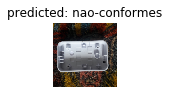

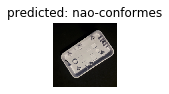

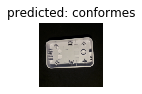

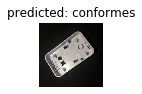

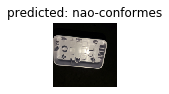

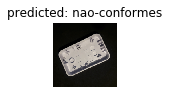

In [56]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [57]:
torch.save(model_conv, 'prediction_conv_model.pth')

C:\Users\bruno\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Inception3. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\bruno\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BasicConv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\bruno\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\bruno\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:

In [58]:
#### Inferência sobre o modelo criado

In [60]:
model=torch.load('prediction_conv_model.pth')

In [61]:
model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
def process_image(image_path):
    # Load Image
    img = Imagem.open(image_path)
    
    # Get the dimensions of the image
    width, height = img.size
    
    # Resize by keeping the aspect ratio, but changing the dimension
    # so the shortest size is 255px
    img = img.resize((255, int(255*(height/width))) if width < height else (int(255*(width/height)), 255))
    
    # Get the dimensions of the new image size
    width, height = img.size
    
    # Set the coordinates to do a center crop of 224 x 224
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    img = img.crop((left, top, right, bottom))
    
    # Turn image into numpy array
    img = np.array(img)
    
    # Make the color channel dimension first instead of last
    img = img.transpose((2, 0, 1))
    
    # Make all values between 0 and 1
    img = img/255
    
    # Normalize based on the preset mean and standard deviation
    img[0] = (img[0] - 0.485)/0.229
    img[1] = (img[1] - 0.456)/0.224
    img[2] = (img[2] - 0.406)/0.225
    
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    
    # Turn into a torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    return image

In [64]:
def predict(image, model):
    # Pass the image through our model
    output = model.forward(image)
    
    # Reverse the log function in our output
    output = torch.exp(output)
    
    # Get the top predicted class, and the output percentage for
    # that class
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()

In [65]:
# Show Image
def show_image(image):
    # Convert image to numpy
    image = image.numpy()
    
    # Un-normalize the image
    image[0] = image[0] * 0.226 + 0.445
    
    # Print the image
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

In [66]:
image = process_image("20191103_142524.jpg")

In [67]:
top_prob, top_class = predict(image, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


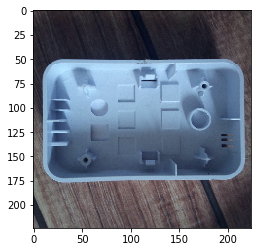

In [68]:
show_image(image)

In [69]:
print('Classe: ',class_names[top_class]  )

Classe:  nao-conformes


In [70]:
data_dir_infer = './data/dataset/val'

In [71]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir_infer, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [72]:
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

In [73]:
images, labels = get_random_images(5)

In [74]:
writer = SummaryWriter('./logs_conv')
writer.add_graph(model, images)

In [149]:
import seaborn as sn
import pandas as pd
from sklearn.metrics import classification_report

In [ ]:
os.chdir('./data/dataset/test/conformes')
conformes = os.listdir('.')

In [109]:
pred_conforme=[]
for conf in conformes:
    image = process_image(conf)
    top_prob, top_class = predict(image, model)
    pred_conforme.append(top_class)

In [115]:
cont_conforme_in_conforme=0
cont_n_conforme_in_conforme=0
for i in pred_conforme:
    if i == 0:
        cont_conforme_in_conforme+=1
    else:
        cont_n_conforme_in_conforme+=1
print('conformes em conformes:',cont_conforme_in_conforme)
print('não conformes em conformes:',cont_n_conforme_in_conforme)

conformes em conformes: 20
não conformes em conformes: 10


In [116]:
os.chdir('../nao-conformes')
nao_conformes = os.listdir('.')

In [128]:
pred_n_conforme=[]
for nconf in nao_conformes:
    image = process_image(nconf)
    top_prob, top_class = predict(image, model)
    pred_n_conforme.append(top_class)

In [129]:
cont_nconforme_in_nconforme=0
cont_conforme_in_nconforme=0
for i in pred_n_conforme:
    if i == 1:
        cont_nconforme_in_nconforme+=1
    else:
        cont_conforme_in_nconforme+=1
print('não-conformes em não-conformes:',cont_nconforme_in_nconforme)
print('conformes em não-conformes:',cont_conforme_in_nconforme)

não-conformes em não-conformes: 28
conformes em não-conformes: 6


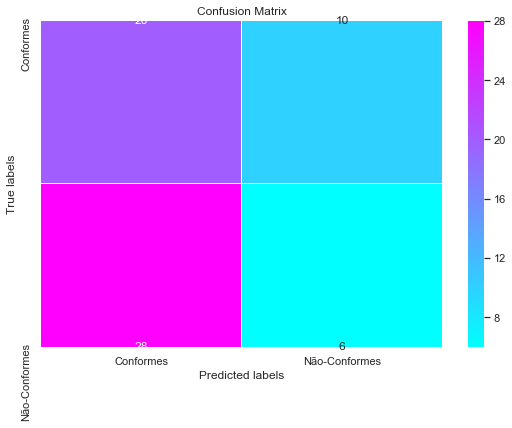

In [154]:
array = [[cont_conforme_in_conforme,cont_n_conforme_in_conforme],
     [cont_conforme_in_nconforme,cont_nconforme_in_nconforme]]        
df_cm = pd.DataFrame(array)
f, ax = plt.subplots(figsize=(9, 6))
sn.set()
sn.heatmap(df_cm, annot=True,ax=ax,linewidths=.5, cmap='cool')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Conformes', 'Não-Conformes']); ax.yaxis.set_ticklabels(['Conformes', 'Não-Conformes']);

In [150]:
conf_test=[]
nconf_test=[]
for i in range(len(pred_conforme)):
    conf_test.append(0)
for i in range(len(pred_n_conforme)):
    nconf_test.append(1)

In [ ]:
from sklearn.metrics import classification_report

In [151]:
print(classification_report(conf_test,pred_conforme))

C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           0       1.00      0.67      0.80        30
           1       0.00      0.00      0.00         0

    accuracy                           0.67        30
   macro avg       0.50      0.33      0.40        30
weighted avg       1.00      0.67      0.80        30



In [152]:
print(classification_report(nconf_test,pred_n_conforme))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.82      0.90        34

    accuracy                           0.82        34
   macro avg       0.50      0.41      0.45        34
weighted avg       1.00      0.82      0.90        34

